<a href="https://colab.research.google.com/github/MedAmine-SUDO/Tunisian-License-Plate-Recognition/blob/master/Model_Evaluation_Test.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
from os import listdir
from xml.etree import ElementTree
from numpy import zeros
from numpy import asarray
from numpy import expand_dims
from numpy import mean
from mrcnn.config import Config
from mrcnn.model import MaskRCNN
from mrcnn.utils import Dataset
from mrcnn.utils import compute_ap
from mrcnn.model import load_image_gt
from mrcnn.model import mold_image
from matplotlib import pyplot
from matplotlib.patches import Rectangle

Using TensorFlow backend.


In [0]:
PATH_TO_ANNOT = "./license_plates_detection_train/annots"

In [0]:
weights
for item in listdir("./licenseplate_cfg20200509T2207"):
    weights.append(item)

weights = weights[1:]


In [0]:
class licensePateDataset(Dataset):
	# load the dataset definitions
	def load_dataset(self, dataset_dir, is_train=True):
		# define one class
		self.add_class("dataset", 1, "licencePlate")
		# define data locations
		images_dir = dataset_dir + '/images/'
		annotations_dir = dataset_dir + '/annots/'
		# find all images
		for filename in listdir(images_dir):
			# extract image id
			image_id = filename[:-4]
			# skip all images after 800 if we are building the train set
			if is_train and int(image_id) >= 720:
				continue
			# skip all images before 800 if we are building the validation set
			if not is_train and int(image_id) < 720:
				continue
			img_path = images_dir + filename
			ann_path = annotations_dir + image_id + '.xml'
			# add to dataset
			self.add_image('dataset', image_id=image_id, path=img_path, annotation=ann_path)
 
	# extract bounding boxes from an annotation file
	def extract_boxes(self, filename):
         tree = ElementTree.parse(filename)
        # get the root of the document
         root = tree.getroot()
        # extract each bounding box
         boxes = list()
         for box in root.findall('.//bndbox'):
             xmin = int(box.find('xmin').text)
             ymin = int(box.find('ymin').text)
             xmax = int(box.find('xmax').text)
             ymax = int(box.find('ymax').text)
             coors = [xmin, ymin, xmax, ymax]
             boxes.append(coors)
        # extract image dimensions
         width = int(root.find('.//size/width').text)
         height = int(root.find('.//size/height').text)
         return boxes, width, height
 
	# load the masks for an image
	def load_mask(self, image_id):
		# get details of image
		info = self.image_info[image_id]
		# define box file location
		path = info['annotation']
		# load XML
		boxes, w, h = self.extract_boxes(path)
		# create one array for all masks, each on a different channel
		masks = zeros([h, w, len(boxes)], dtype='uint8')
		# create masks
		class_ids = list()
		for i in range(len(boxes)):
			box = boxes[i]
			row_s, row_e = box[1], box[3]
			col_s, col_e = box[0], box[2]
			masks[row_s:row_e, col_s:col_e, i] = 1
			class_ids.append(self.class_names.index('licencePlate'))
		return masks, asarray(class_ids, dtype='int32')
 
	# load an image reference
	def image_reference(self, image_id):
		info = self.image_info[image_id]
		return info['path']

In [0]:
# define a configuration for the model
class LicensePlateConfig(Config):
	# define the name of the configuration
	NAME = "LicensePlate_cfg"
	# number of classes (background + License Plate)
	NUM_CLASSES = 1 + 1
	# number of training steps per epoch
	STEPS_PER_EPOCH = 131
	# simplify GPU config
	GPU_COUNT = 1
	IMAGES_PER_GPU = 1

In [0]:
# calculate the mAP for a model on a given dataset
def evaluate_model(dataset, model, cfg):
	APs = list()
	for image_id in dataset.image_ids:
		# load image, bounding boxes and masks for the image id
		image, image_meta, gt_class_id, gt_bbox, gt_mask = load_image_gt(dataset, cfg, image_id, use_mini_mask=False)
		# convert pixel values (e.g. center)
		scaled_image = mold_image(image, cfg)
		# convert image into one sample
		sample = expand_dims(scaled_image, 0)
		# make prediction
		yhat = model.detect(sample, verbose=0)
		# extract results for first sample
		r = yhat[0]
		# calculate statistics, including AP
		AP, _, _, _ = compute_ap(gt_bbox, gt_class_id, gt_mask, r["rois"], r["class_ids"], r["scores"], r['masks'])
		# store
		APs.append(AP)
	# calculate the mean AP across all images
	mAP = mean(APs)
	return mAP

In [0]:
# train set
train_set = licensePateDataset()
train_set.load_dataset('./license_plates_detection_train', is_train=True)
train_set.prepare()
print('Train: %d' % len(train_set.image_ids))
 
# test/val set
test_set = licensePateDataset()
test_set.load_dataset('./license_plates_detection_train', is_train=False)
test_set.prepare()
print('Test: %d' % len(test_set.image_ids))

Train: 719
Test: 181


In [0]:
# prepare config
config = LicensePlateConfig()

In [0]:
# define the model
model = MaskRCNN(mode='inference', model_dir='./', config=config)








Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
Instructions for updating:
box_ind is deprecated, use box_indices instead


Instructions for updating:
Use `tf.cast` instead.


In [0]:
#i = 1
#trainMap = []
#testMap = []
#for weight in weights:
# load weights 
model.load_weights('./licenseplate_cfg20200509T2207/mask_rcnn_licenseplate_cfg_0031.h5', by_name=True)
# evaluate model on training dataset 
# Uncomment if you want to evaluate the train mAP(mean average precision)
train_mAP = evaluate_model(train_set, model, config)
#trainMap.append(train_mAP)
print("Train mAP: %.3f" % train_mAP)
# evaluate model on test dataset
# Uncomment if you want to evaluate the test
test_mAP = evaluate_model(test_set, model, config)
#testMap.append(test_mAP)
print("Test mAP: %.3f" % test_mAP)
#print("[epoch"+str(i)+"]: Done...")
#i = i + 1 

Re-starting from epoch 31
Train mAP: 0.983
Test mAP: 0.975


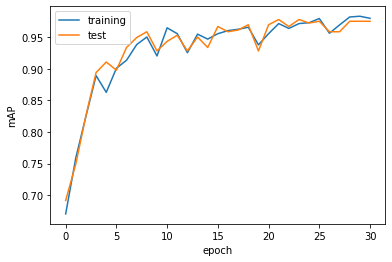

In [0]:
pyplot.plot(trainMap)
pyplot.plot(testMap)
pyplot.xlabel("epoch")
pyplot.ylabel("mAP")
pyplot.legend(['training', 'test'], loc="upper left")
pyplot.show()

In [0]:
model.load_weights("./licenseplate_cfg20200509T2207/mask_rcnn_licenseplate_cfg_0031.h5", by_name=True)

In [0]:
# plot a number of photos with ground truth and predictions
def plot_actual_vs_predicted(dataset, model, cfg, n_images=5):
	# load image and mask
	for i in range(n_images):
		pyplot.figure(figsize=(15,20))
		# load the image and mask
		image = dataset.load_image(i+10)
		mask, _ = dataset.load_mask(i+10)
		# convert pixel values (e.g. center)
		scaled_image = mold_image(image, cfg)
		# convert image into one sample
		sample = expand_dims(scaled_image, 0)
		# make prediction
		yhat = model.detect(sample, verbose=0)[0]
		# define subplot
		pyplot.subplot(n_images, 2, i*2+1)
		# plot raw pixel data
		pyplot.imshow(image)
		pyplot.title('Actual')
		# plot masks
		for j in range(mask.shape[2]):
			pyplot.imshow(mask[:, :, j], cmap='gray', alpha=0.3)
		# get the context for drawing boxes
		pyplot.subplot(n_images, 2, i*2+2)
		# plot raw pixel data
		pyplot.imshow(image)
		pyplot.title('Predicted')
		ax = pyplot.gca()
		# plot each box
		for box in yhat['rois']:
			# get coordinates
			y1, x1, y2, x2 = box
			# calculate width and height of the box
			width, height = x2 - x1, y2 - y1
			# create the shape
			rect = Rectangle((x1, y1), width, height, fill=False, color='red')
			# draw the box
			ax.add_patch(rect)
	# show the figure
	pyplot.show()

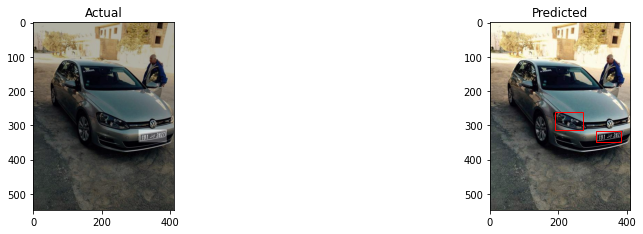

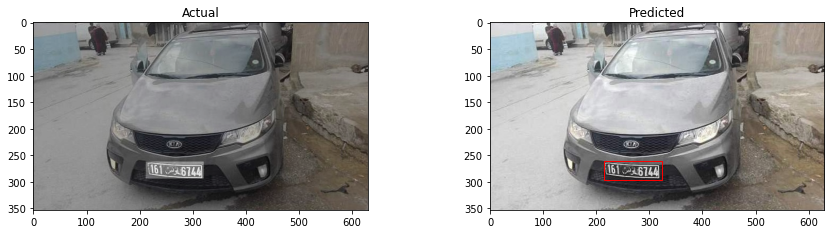

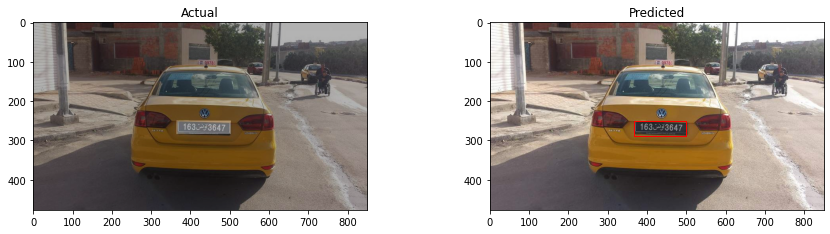

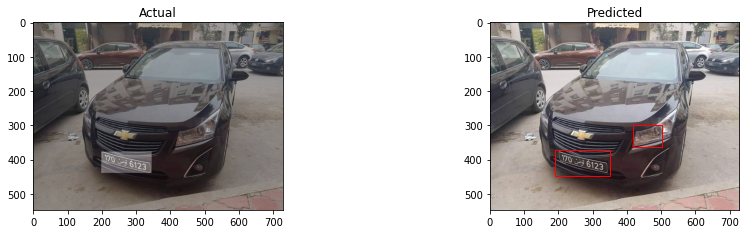

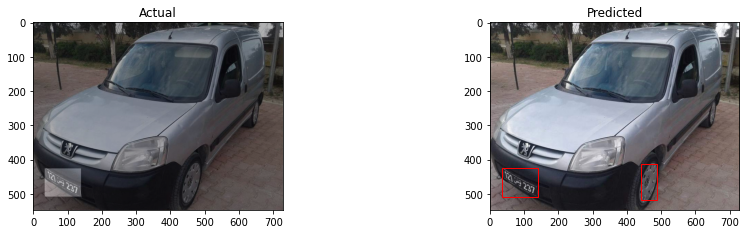

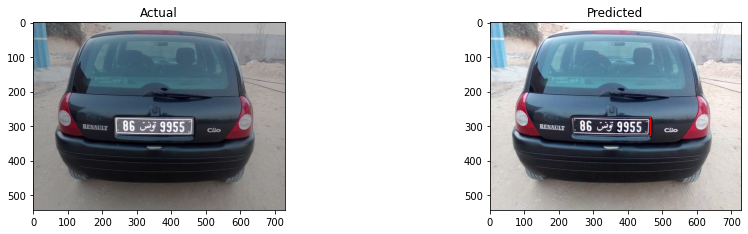

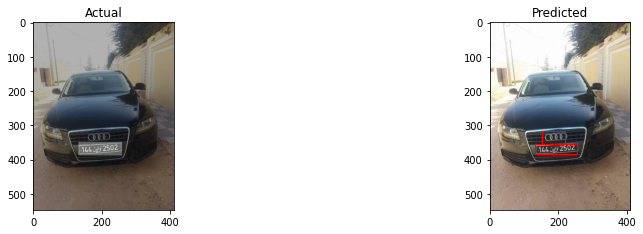

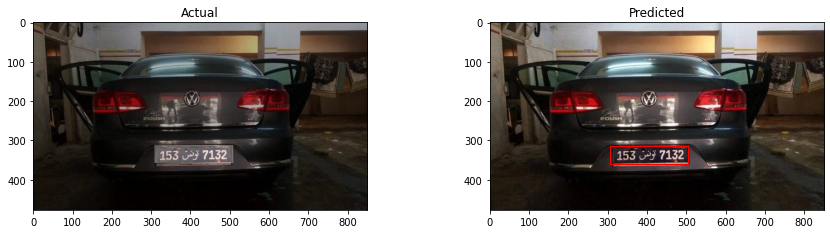

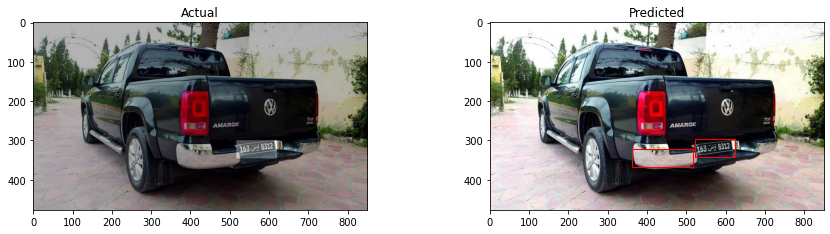

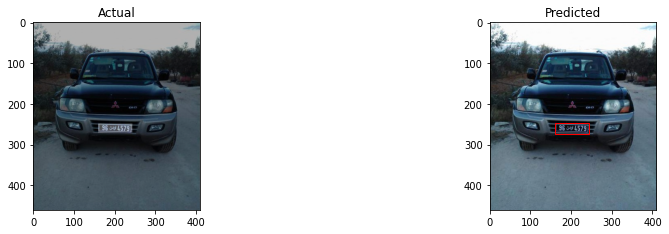

In [0]:
# plot predictions for train dataset
plot_actual_vs_predicted(train_set, model, config)
# plot predictions for test dataset
plot_actual_vs_predicted(test_set, model, config)